# Imports

In [1]:
# local imports
from scripts.data import SimulationData
from scripts.nn import *
from scripts.loss import *

# data manipulation
import torch
from torch import nn, optim
import numpy as np
import os
import pandas as pd

# visualization
import matplotlib.pyplot as plt

# Setup

#### data global variables

In [2]:
N_STEPS = 100
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

DATA_PATH = 'data/'
SIMULATIONS_FILE_NAME = os.path.join(DATA_PATH, 'generated_simulations_n.pt')
ANCHORS_FILE_NAME = os.path.join(DATA_PATH, 'anchors_pos.pt')
CAL_FILE_NAME = os.path.join(DATA_PATH, 'calibration_data')

RESULTS_PATH = 'results/'

#### Neural network global variables

In [3]:
BATCH_SIZE = 1
N_EPOCHS = 500

# Generate positions

#### Generation

In [5]:
def generate_gaussian_simulations(min_x, max_x, min_y, max_y, n_steps, step_size=1, std=0.1):
    assert min_x <= max_x
    assert min_y <= max_y
    
    # generate starting position
    start_x = min_x + (max_x - min_x) * torch.rand(1)
    start_y = min_y + (max_y - min_y) * torch.rand(1)
    
    cur_angle = 2 * np.pi * torch.rand(1) - np.pi
    deviations = 2 * np.pi * torch.empty(n_steps - 1).normal_(mean=0, std=std)
    
    positions = [[start_x, start_y]]
    cur_x, cur_y = start_x, start_y
    
    for dev in deviations:
        cur_angle = cur_angle + dev
        
        # put angle into (-pi, pi] range
        if cur_angle > np.pi:
            cur_angle.sub_(2 * np.pi)
        elif cur_angle <= -np.pi:
            cur_angle.add_(2 * np.pi)
            
        cur_x = cur_x + step_size * torch.cos(cur_angle)
        cur_y = cur_y + step_size * torch.sin(cur_angle)
        
            
        # handle positions crossing the boundary (reflected like a mirror)
        if cur_x < min_x:
            cur_angle = torch.sign(cur_angle) * np.pi - cur_angle
            cur_x = min_x + (min_x - cur_x)
        elif cur_x > max_x:
            cur_angle = torch.sign(cur_angle) * np.pi - cur_angle
            cur_x = max_x + (max_x - cur_x)
            
        if cur_y < min_y:
            cur_angle = -cur_angle
            cur_y = min_y + (min_y - cur_y)
        elif cur_y > max_y:
            cur_angle = -cur_angle
            cur_y = max_y + (max_y - cur_y)
        
        positions.append([cur_x, cur_y])
        
    return torch.FloatTensor(positions)

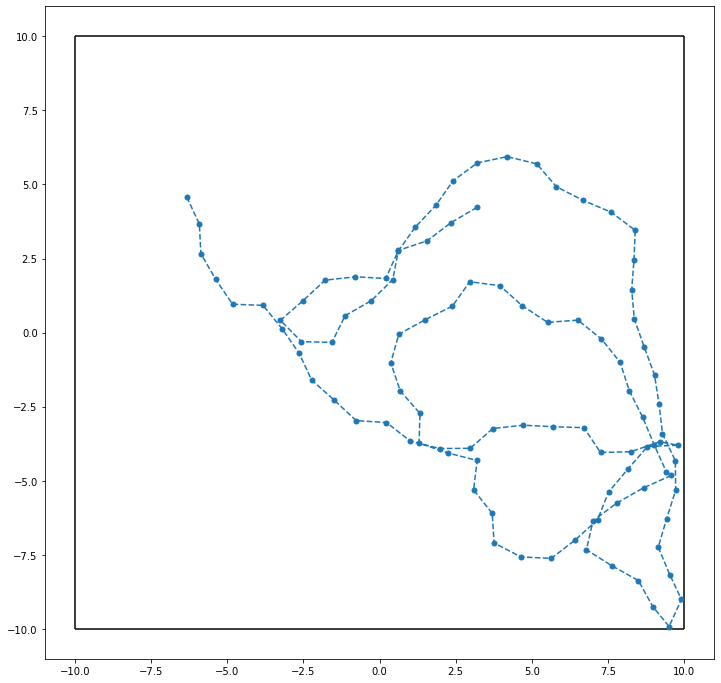

In [117]:
pos = generate_gaussian_simulations(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS, step_size=1, std=0.1)
plt.figure(figsize=(12,12))
plt.plot(*pos.transpose(0,1), '.--', markersize=10)
plt.vlines([MIN_X, MAX_X], MIN_Y, MAX_Y)
plt.hlines([MIN_Y, MAX_Y], MIN_X, MAX_X)

In [158]:
simulations = torch.stack([
    generate_gaussian_simulations(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS, 0.5, 0.1)
for i in range(N_SIMULATIONS)])

#### Save

In [159]:
torch.save(simulations, SIMULATIONS_FILE_NAME)

#### Load

In [4]:
simulations = torch.load(SIMULATIONS_FILE_NAME)
anchors_pos = torch.load(ANCHORS_FILE_NAME)

In [7]:
kwargs = {
    'rssi_std': 2.5,
    'rtt_std': 2
}

In [10]:
data = SimulationData(simulations, anchors_pos, **kwargs)

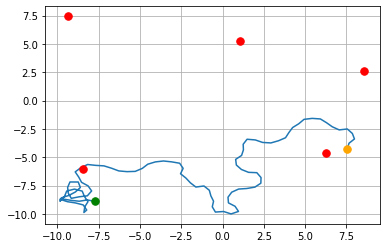

In [11]:
data.plot_simulation(data[0][1])

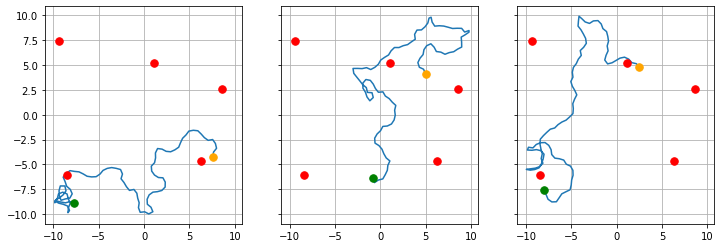

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,4))

data.plot_simulation(data[0][1], ax=ax1)
data.plot_simulation(data[1][1], ax=ax2)
data.plot_simulation(data[2][1], ax=ax3)

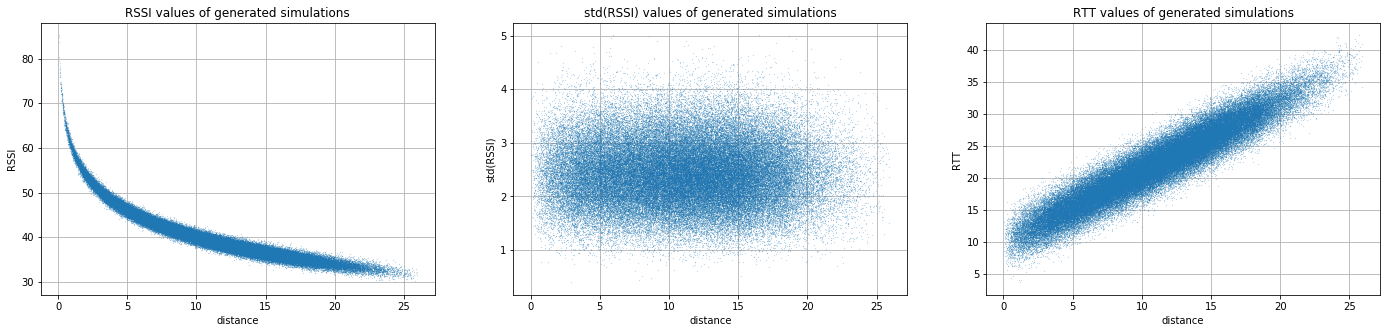

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))

dist = data.distances.view(-1)
feat = data[:][0][:,:,:5].reshape(-1)
ax1.set_title('RSSI values of generated simulations')
ax1.grid()
ax1.set_xlabel('distance')
ax1.set_ylabel('RSSI')
ax1.plot(dist, feat, '.', markersize=0.2)

dist = data.distances.view(-1)
feat = data[:][0][:,:,5:10].reshape(-1)
ax2.set_title('std(RSSI) values of generated simulations')
ax2.grid()
ax2.set_xlabel('distance')
ax2.set_ylabel('std(RSSI)')
ax2.plot(dist, feat, '.', markersize=0.2)

dist = data.distances.view(-1)
feat = data[:][0][:,:,10:].reshape(-1)
ax3.set_title('RTT values of generated simulations')
ax3.grid()
ax3.set_xlabel('distance')
ax3.set_ylabel('RTT')
ax3.plot(dist, feat, '.', markersize=0.2);

# Generate calibration data

#### Generation

In [5]:
def rand_uniform(*size, min_=0, max_=1):
    return torch.rand(size) * (max_ - min_) + min_

def generate_calibration_data(n_sims, n_samples, x_bounds, y_bounds):
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds

    # generate horizontal calibration data
    ys = rand_uniform(n_sims, min_=min_y, max_=max_y).unsqueeze(1).repeat(1, n_samples)
    xs = torch.linspace(min_x, max_x, n_samples).unsqueeze(0).repeat(n_sims, 1)
    horizontal_sims = torch.stack((xs, ys), 2)
    
    # generate vertical calibration data
    xs = rand_uniform(n_sims, min_=min_x, max_=max_x).unsqueeze(1).repeat(1, n_samples)
    ys = torch.linspace(min_y, max_y, n_samples).unsqueeze(0).repeat(n_sims, 1)
    vertical_sims = torch.stack((xs, ys), 2)
    
    return horizontal_sims, vertical_sims

In [6]:
horizontal_sims, vertical_sims = generate_calibration_data(N_SIMULATIONS // 2, N_STEPS, [MIN_X, MAX_X], [MIN_Y, MAX_Y])

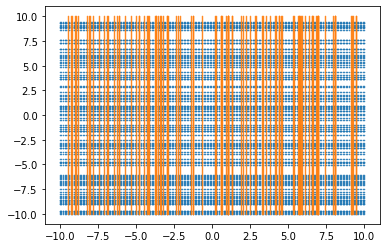

In [7]:
plt.plot(*horizontal_sims.view(-1, 2).t(), '.', markersize=1)
plt.plot(*vertical_sims.view(-1, 2).t(), '.', markersize=1)

#### Save

In [11]:
torch.save([horizontal_sims, vertical_sims], CAL_FILE_NAME)

#### Load

In [11]:
horizontal_sims, vertical_sims = torch.load(CAL_FILE_NAME)

#### Transform into dataset

In [12]:
horizontal_cal_data = SimulationData(horizontal_sims, anchors_pos)
vertical_cal_data = SimulationData(vertical_sims, anchors_pos)

# Train without calibration

In [16]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = data.feature_dim
bot_dim = 2
hid_dim = 12

### Testing different embedding dimensions

#### Train

In [15]:
bot_dims = [2,3,4,5,6]
n_dims = len(bot_dims)

NameError: name 'hid_dims' is not defined

In [26]:
models = {}
for bd in bot_dims:
    model = create_autoencoder_model(input_dim, hid_dim, bd)
    model = Model(model)
    optimizer = optim.Adam(model.model.parameters(), lr=0.005)
    model.train_eval(train_loader, test_loader, optimizer, 5 * N_EPOCHS)
    
    models[bd] = model

100%|██████████| 2500/2500 [09:50<00:00,  4.24it/s]


In [35]:
bd = 10

model = create_autoencoder_model(input_dim, hid_dim, bd)
model = Model(model)
optimizer = optim.Adam(model.model.parameters(), lr=0.005)
model.train_eval(train_loader, test_loader, optimizer, 5 * N_EPOCHS)

models[bd] = model

100%|██████████| 2500/2500 [09:39<00:00,  4.31it/s]


#### Save

In [27]:
for bd in bot_dims:
    path = os.path.join(RESULTS_PATH, f'pc_autoencoder_embedding_{bd}D')
    models[bd].save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Load 

In [74]:
models = {}
for bd in bot_dims:
    path = os.path.join(RESULTS_PATH, f'pc_autoencoder_embedding_{bd}D')
    models[bd] = Model.load(path)

In [42]:
n_dims = 5

Text(0.5, 0, 'epoch')

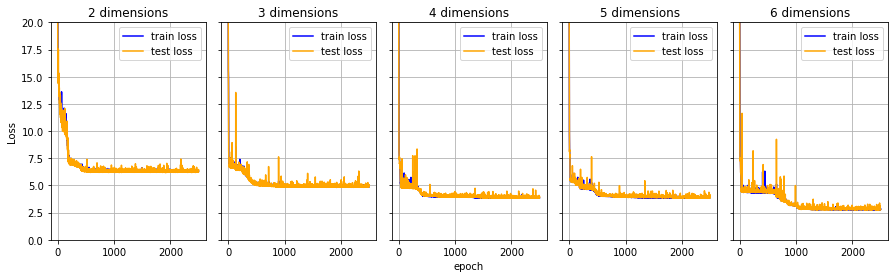

In [81]:
fig, axes = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 4))
plt.grid()
plt.subplots_adjust(wspace=0.1)

for i in range(n_dims):
    bd = bot_dims[i]
    
    ax = axes[i % 5] if n_dims <= 5 else axes[i // 5, i % 5]
    
    ax.grid(True)
    ax.plot(models[bd].train_loss, c='blue')
    ax.plot(models[bd].test_loss, c='orange')
    ax.legend(['train loss', 'test loss'])
    ax.set_title(f'{bd} dimensions')
    
plt.ylim(0, 20)
axes[0].set_ylabel('Loss')
axes[2].set_xlabel('epoch')

### Recovery loss

#### Train

In [17]:
model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
model = Model(model)
optimizer = optim.Adam(model.model.parameters(), lr=0.005)
model.train_eval(train_loader, test_loader, optimizer, 5 * N_EPOCHS)

100%|██████████| 2500/2500 [09:40<00:00,  4.31it/s]


#### Save

In [20]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_2D_embedding_low')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Load 

In [21]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_2D_embedding_low')
model = Model.load(path)

#### Visualize

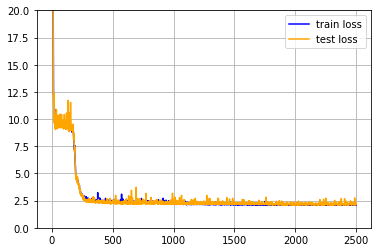

In [22]:
model.plot_loss([0,20])

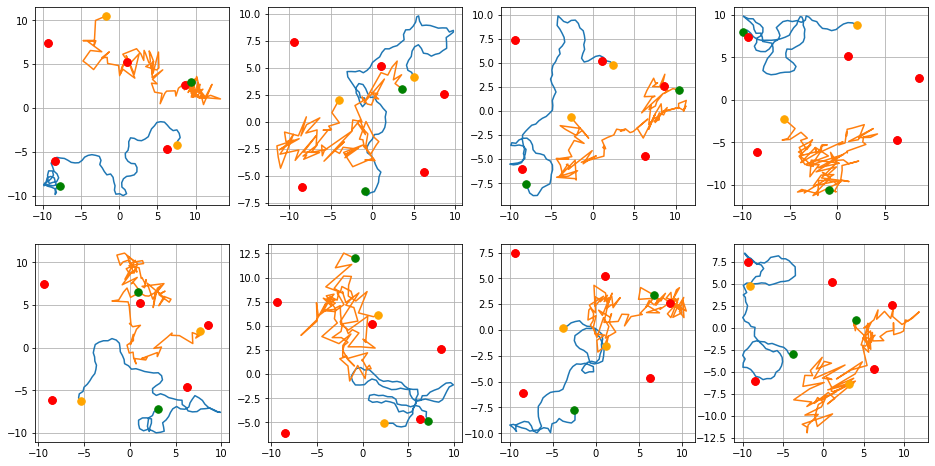

In [24]:
model.plot_embedding_on_simulation(data, range(8))

### Fixed points

#### Train

In [30]:
loss_functions = [
    {
        'name': 'reconstruction',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
model = ModelMultiLoss(model, loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, 3 * N_EPOCHS)

100%|██████████| 1500/1500 [06:51<00:00,  3.65it/s]


#### Save

In [31]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points_low')
model.save(path)

#### Load

In [32]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points_low')
model = ModelMultiLoss.load(path)

#### Visualize

Text(0.5, 0, 'epoch')

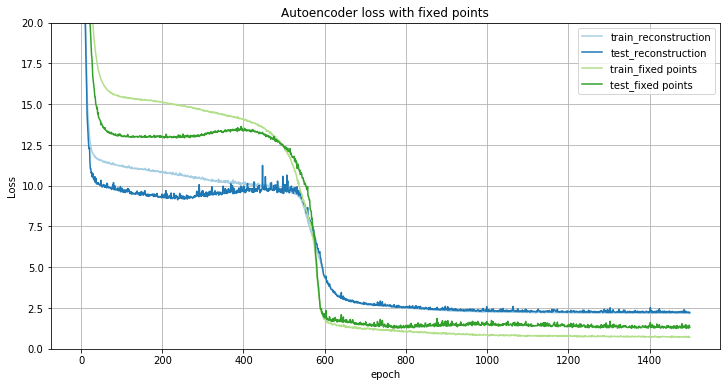

In [33]:
model.plot_loss([0,20])
plt.title('Autoencoder loss with fixed points')
plt.ylabel('Loss')
plt.xlabel('epoch')

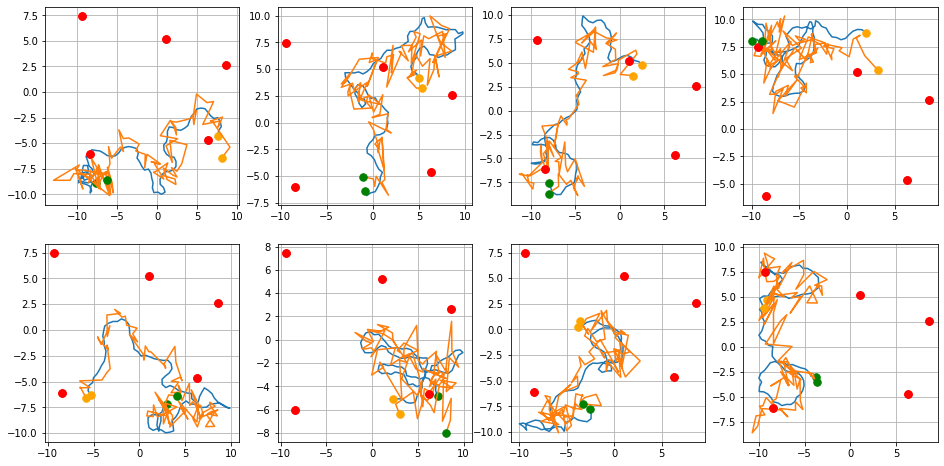

In [34]:
model.plot_embedding_on_simulation(data, range(8))

### IMU

#### Train

In [53]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'imu',
        'function': imu_loss,
        'weight': 5.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points_low')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


#### Save

In [54]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_imu_low')
model.save(path)

#### Load

In [55]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_imu_low')
model = ModelMultiLoss.load(path)

#### Visualize

Text(0.5, 0, 'epoch')

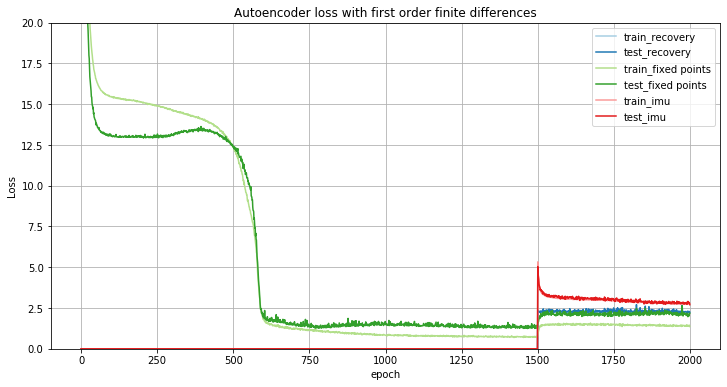

In [56]:
model.plot_loss([0,20])
plt.title('Autoencoder loss with first order finite differences')
plt.ylabel('Loss')
plt.xlabel('epoch')

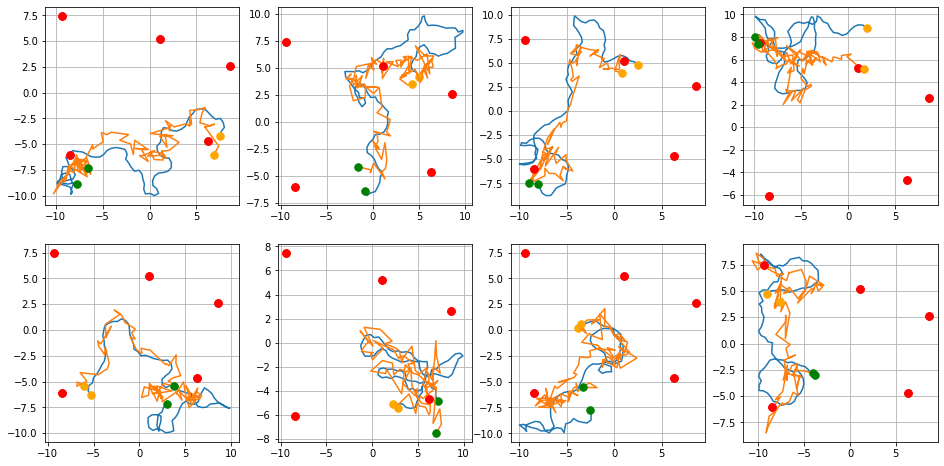

In [57]:
model.plot_embedding_on_simulation(data, range(8))

### Second order central difference

#### Train

In [22]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 5.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points_low')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [02:51<00:00,  2.91it/s]


#### Save

In [39]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_second_order_low')
model.save(path)

#### Load

In [40]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_second_order_low')
model = ModelMultiLoss.load(path)

#### Visualize

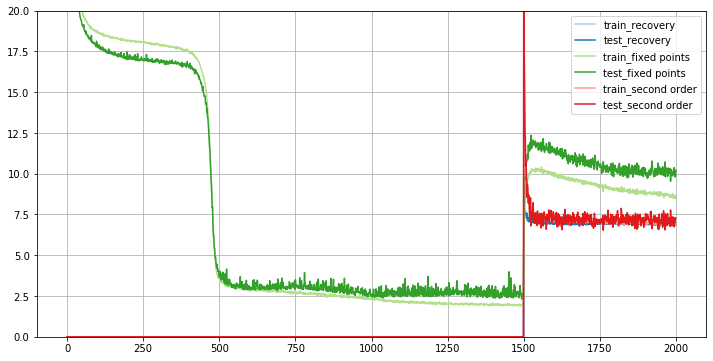

In [20]:
model.plot_loss([0,20])

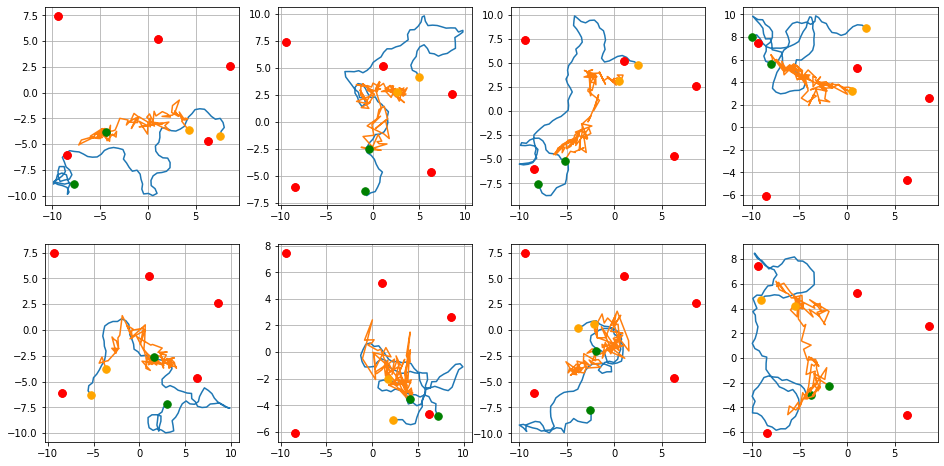

In [25]:
model.plot_embedding_on_simulation(data, range(8))

# Train with calibration

#### Train

In [30]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

loss_functions_cal = [
    {
        'name': 'recovery_cal',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed_points_cal',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'calibration',
        'function': calibration_loss,
        'weight': 1.0
    }
]

model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
model = ModelWithCalibration(model, loss_functions, loss_functions_cal)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
optimizer_cal = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, horizontal_cal_data, vertical_cal_data, optimizer_cal, 3 * N_EPOCHS)

100%|██████████| 1500/1500 [15:57<00:00,  1.57it/s]


#### Save

In [31]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_calibration')
model.save(path)

#### Load

In [32]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_calibration')
model = ModelWithCalibration.load(path)

#### Visualize

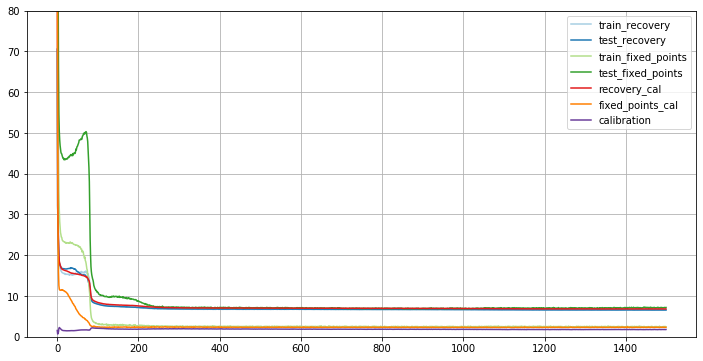

In [33]:
model.plot_loss([0,80])

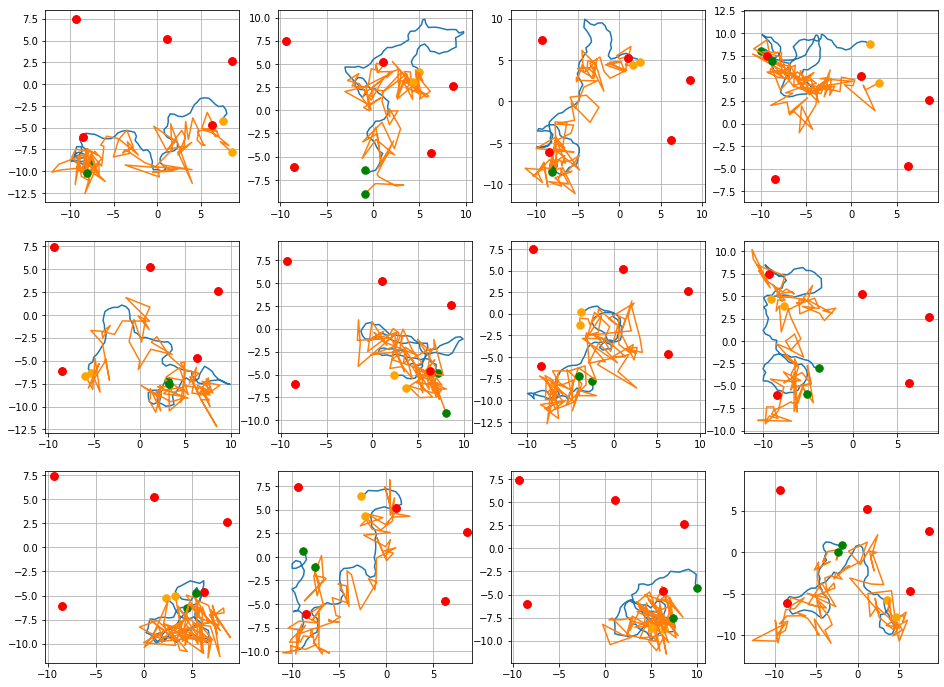

In [34]:
model.plot_embedding_on_simulation(data, range(12))

# With convolution

In [9]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = data.feature_dim
hid_dim = 12
bot_dim = 2
kernel_size = 11

#### Autoencoder architecture with convolution

In [10]:
class Conv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        assert kernel_size % 2 == 1
        
        self.padder = nn.ReplicationPad1d(kernel_size // 2)
        self.conv = nn.Conv1d(input_dim, output_dim, kernel_size)
        
    def forward(self, x):
        single = x.dim() == 2
        
        x = x.transpose(-1, -2)
        
        if single:
            x = x.unsqueeze(0)
            
        src = self.padder(x)
        out = self.conv(src)
            
        if single:
            out = out.squeeze(0)
            
        out = out.transpose(-1, -2)
        return out

In [11]:
class ConvInv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        
        assert kernel_size % 2 == 1
        
        self.padder = nn.ReplicationPad1d(kernel_size // 2)
        self.conv = nn.ConvTranspose1d(input_dim, output_dim, kernel_size)
        
    def forward(self, x):
        single = x.dim() == 2
        
        x = x.transpose(-1, -2)

        if single:
            x = x.unsqueeze(0)
            
        src = self.padder(x)
        out = self.conv(src)
            
        if single:
            out = out.squeeze(0)
            
        out = out[..., self.kernel_size - 1: -(self.kernel_size - 1)]
        out = out.transpose(-1, -2)
            
        return out

In [12]:
def create_conv_autoencoder_model(input_dim, hid_dim, bot_dim, kernel_size=9, activation=nn.ReLU()):
    encoder = nn.Sequential(
        Conv(input_dim, hid_dim, kernel_size), activation,
        nn.Linear(hid_dim, bot_dim)
    )

    decoder = nn.Sequential(
        nn.Linear(bot_dim, hid_dim), activation,
        ConvInv(hid_dim, input_dim, kernel_size)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )

    return model

In [14]:
model = create_conv_autoencoder_model(input_dim, 30, 2)
model

Sequential(
  (0): Sequential(
    (0): Conv(
      (padder): ReplicationPad1d((4, 4))
      (conv): Conv1d(15, 30, kernel_size=(9,), stride=(1,))
    )
    (1): ReLU()
    (2): Linear(in_features=30, out_features=2, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): ConvInv(
      (padder): ReplicationPad1d((4, 4))
      (conv): ConvTranspose1d(30, 15, kernel_size=(9,), stride=(1,))
    )
  )
)

### Recovery loss

#### train

In [18]:
model = create_conv_autoencoder_model(input_dim, hid_dim, bot_dim, kernel_size)
model = Model(model)
optimizer = optim.Adam(model.model.parameters(), lr=0.002)
model.train_eval(train_loader, test_loader, optimizer, 2 * N_EPOCHS)

100%|██████████| 1000/1000 [13:22<00:00,  1.25it/s]


#### Save

In [21]:
path = os.path.join(RESULTS_PATH, 'pc_convolutional_autoencoder')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReplicationPad1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + 

#### Load 

In [22]:
path = os.path.join(RESULTS_PATH, 'pc_convolutional_autoencoder')
model = Model.load(path)

#### Visualize

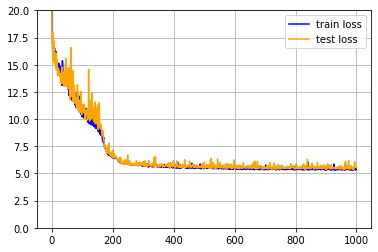

In [23]:
model.plot_loss([0,20])

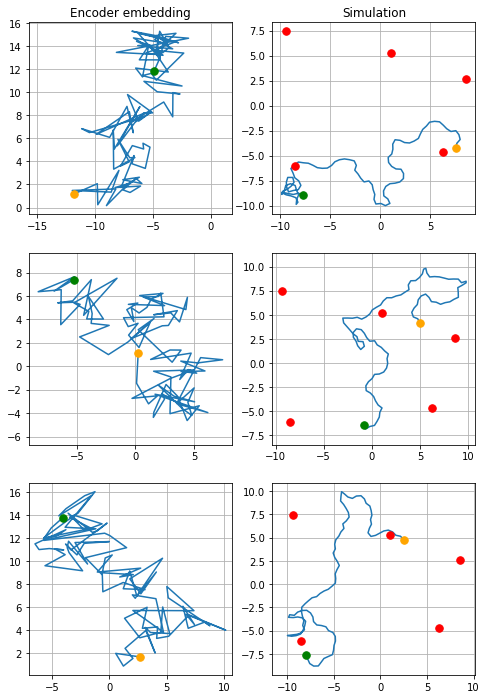

In [24]:
model.plot_embedding(data, range(3))

### Fixed points 

#### Train

In [10]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

model = create_conv_autoencoder_model(input_dim, hid_dim, bot_dim, kernel_size)
model = ModelMultiLoss(model, loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, 2 * N_EPOCHS)

100%|██████████| 1000/1000 [12:34<00:00,  1.32it/s]


#### Save

In [11]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReplicationPad1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + 

#### Load

In [12]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)

#### Visualize

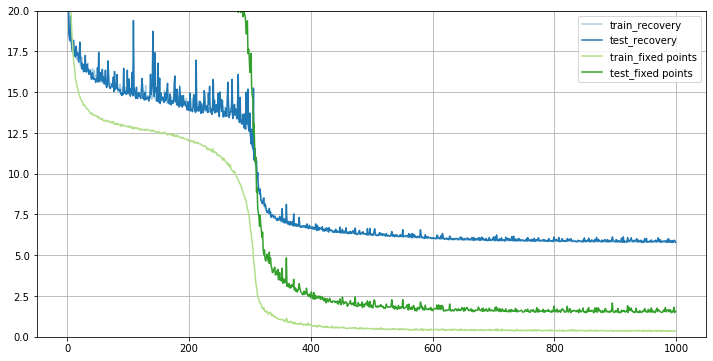

In [13]:
model.plot_loss([0,20])

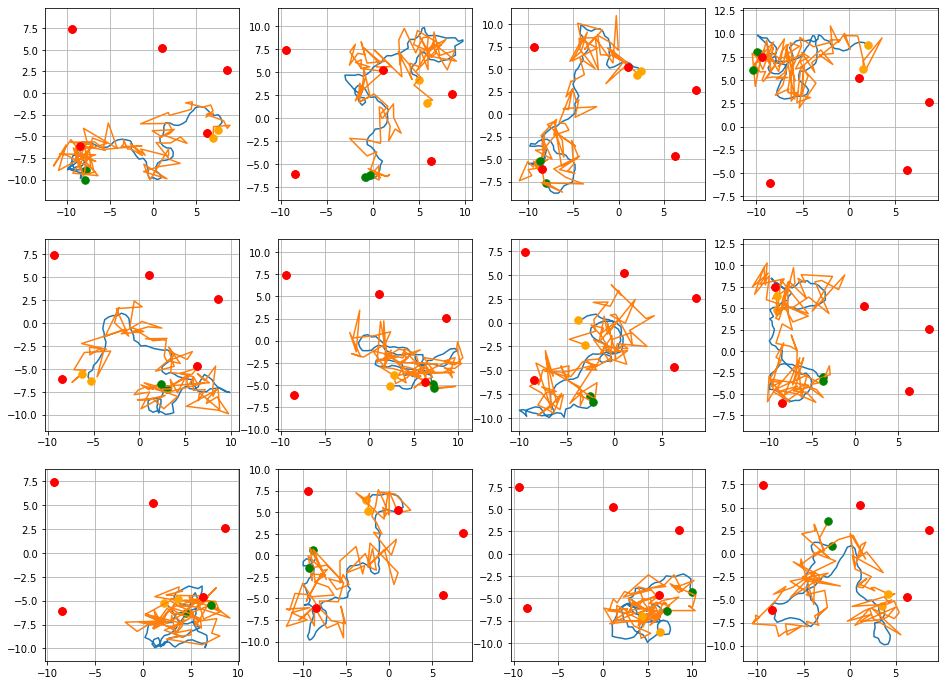

In [14]:
model.plot_embedding_on_simulation(data, range(12))

### IMU

#### Train

In [15]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'imu',
        'function': imu_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [06:55<00:00,  1.20it/s]


#### Save

In [16]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_imu')
model.save(path)

#### Load

In [17]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_imu')
model = ModelMultiLoss.load(path)

#### Visualize

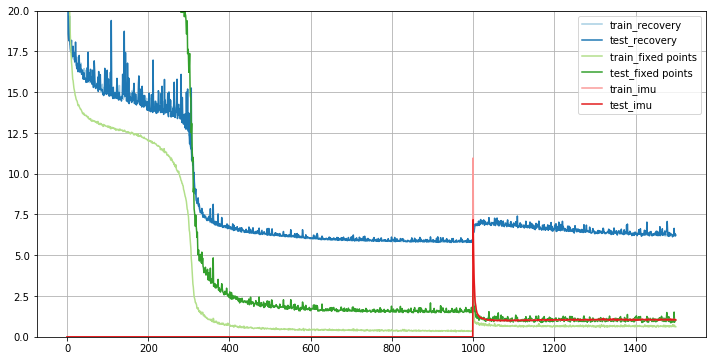

In [18]:
model.plot_loss([0,20])

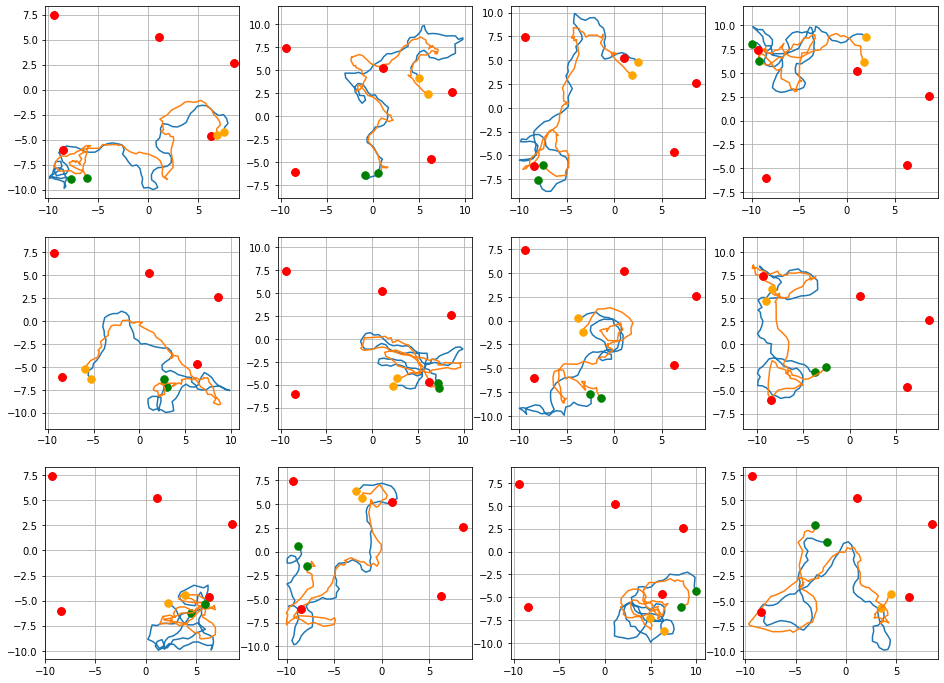

In [19]:
model.plot_embedding_on_simulation(data, range(12))

### Second order

#### Train

In [20]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


#### Save

In [21]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_second_order')
model.save(path)

#### Load

In [22]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_second_order')
model = ModelMultiLoss.load(path)

#### Visualize

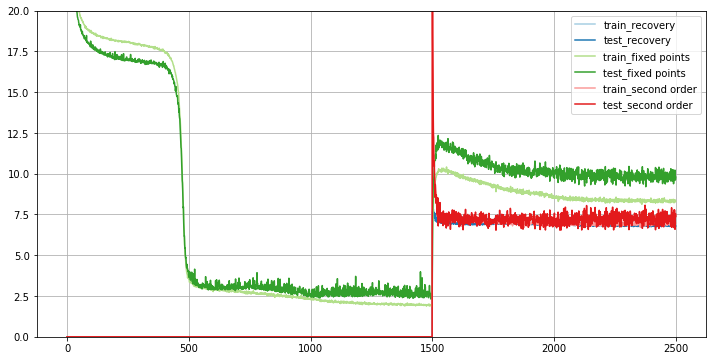

In [23]:
model.plot_loss([0,20])

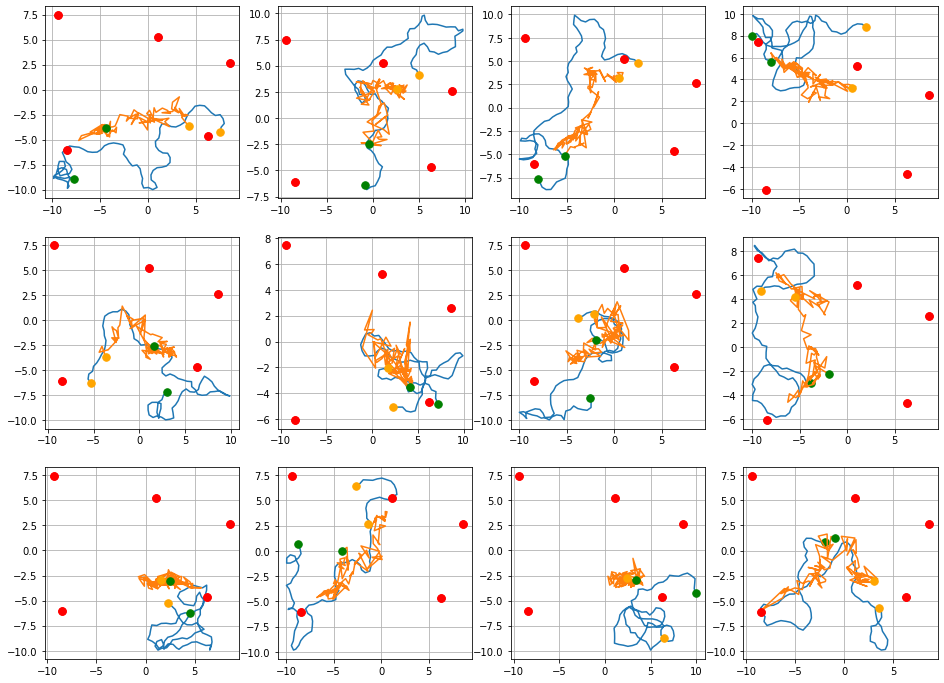

In [24]:
model.plot_embedding_on_simulation(data, range(12))

### Everything

#### Train

In [25]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 10.0
    }, {
        'name': 'imu',
        'function': imu_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [07:44<00:00,  1.08it/s]


#### Save

In [26]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_all')
model.save(path)

#### Load

In [27]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_all')
model = ModelMultiLoss.load(path)

#### Visualize

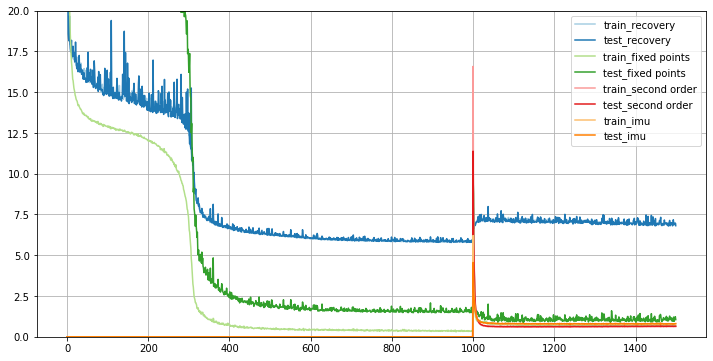

In [28]:
model.plot_loss([0,20])

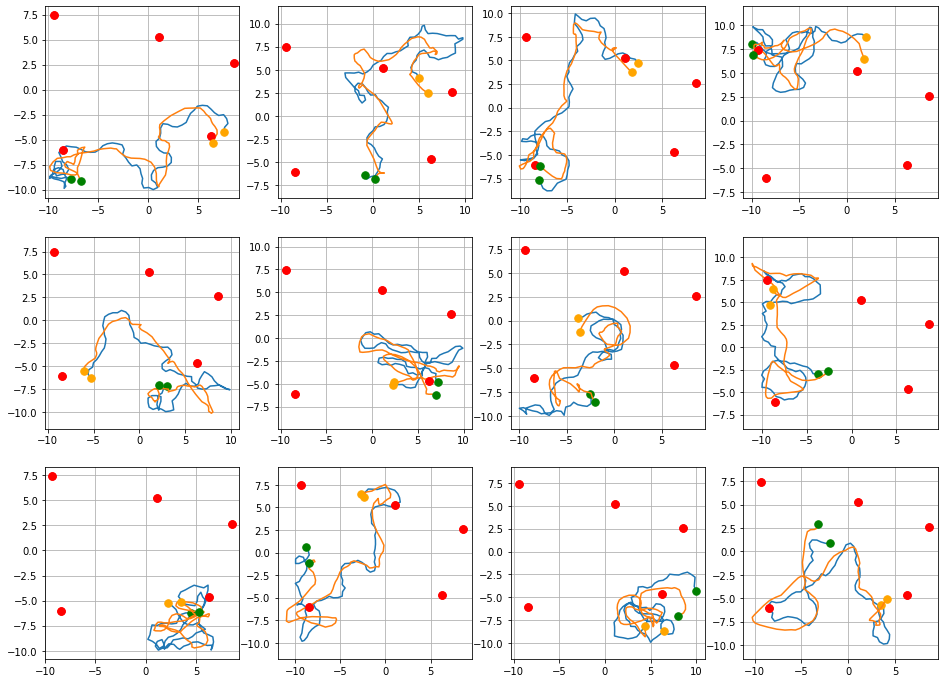

In [29]:
model.plot_embedding_on_simulation(data, range(12))

### With everything and calibration

#### Train 

In [30]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 10.0
    }
]

loss_functions_cal = [
    {
        'name': 'recovery_cal',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed_points_cal',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'calibration',
        'function': calibration_loss,
        'weight': 1.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model = ModelWithCalibration.from_ModelMultiLoss(model, loss_functions, loss_functions_cal)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
optimizer_cal = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, horizontal_cal_data, vertical_cal_data, optimizer_cal, 2 * N_EPOCHS)

100%|██████████| 1000/1000 [31:01<00:00,  1.86s/it]


#### Save

In [31]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_cal_all')
model.save(path)

#### Load

In [32]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_cal_all')
model = ModelMultiLoss.load(path)

#### Visualize

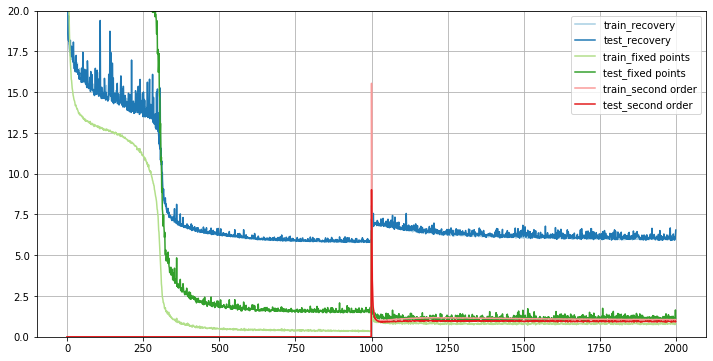

In [33]:
model.plot_loss([0,20])

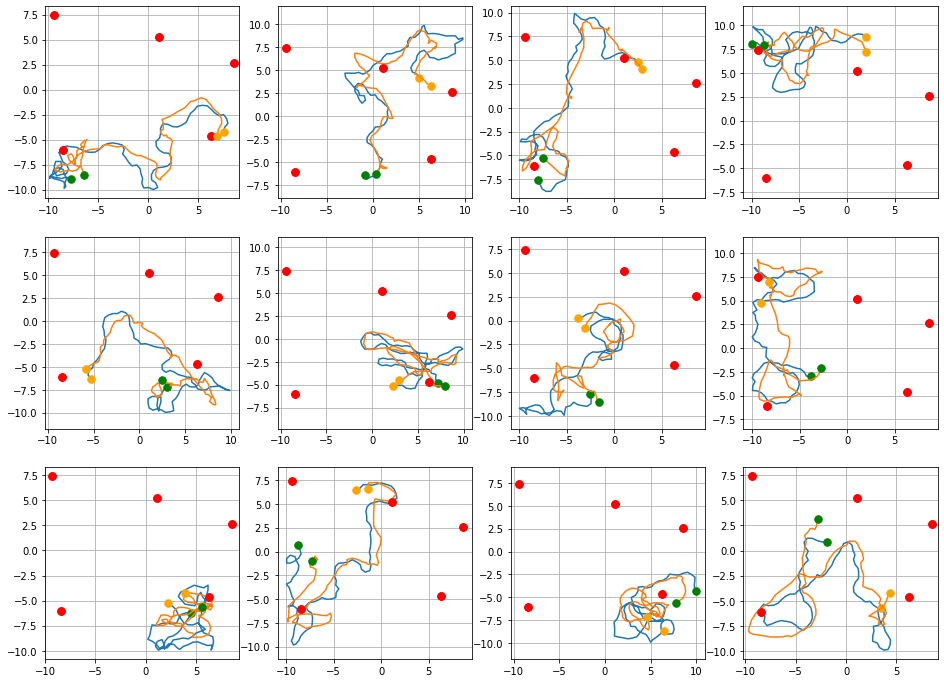

In [34]:
model.plot_embedding_on_simulation(data, range(12))